In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report


# DATA CLEANING & EDA

In [2]:
# This may take a while (~1 min)
# !unzip /Users/naimaamraan/Downloads/Transformed_Combined_Flights_2021.csv.zip

In [3]:
# load raw data
# This may take a while (2-3 min)
df_raw = pd.read_csv('Combined_Flights_2021.csv')
df_raw.head()

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,...,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings
0,2021-03-03,SkyWest Airlines Inc.,SGU,PHX,False,False,724,714.0,0.0,-10.0,...,724.0,813.0,5.0,843,-25.0,0.0,-2.0,0800-0859,2,0.0
1,2021-03-03,SkyWest Airlines Inc.,PHX,SGU,False,False,922,917.0,0.0,-5.0,...,940.0,1028.0,3.0,1040,-9.0,0.0,-1.0,1000-1059,2,0.0
2,2021-03-03,SkyWest Airlines Inc.,MHT,ORD,False,False,1330,1321.0,0.0,-9.0,...,1336.0,1445.0,16.0,1530,-29.0,0.0,-2.0,1500-1559,4,0.0
3,2021-03-03,SkyWest Airlines Inc.,DFW,TRI,False,False,1645,1636.0,0.0,-9.0,...,1703.0,1955.0,7.0,2010,-8.0,0.0,-1.0,2000-2059,4,0.0
4,2021-03-03,SkyWest Airlines Inc.,PHX,BFL,False,False,1844,1838.0,0.0,-6.0,...,1851.0,1900.0,3.0,1925,-22.0,0.0,-2.0,1900-1959,2,0.0


In [4]:
# get shape of raw data: 6311871 instances, 61 columns
df_raw.shape

(6311871, 61)

In [5]:
# checking if data is concentrated around specific time of year, month, week
# - No, we are good.

# # we can drop year since all records are from 2021
# df_raw.Year.value_counts()

# # we can keep Quarter
# df_raw.Quarter.value_counts()

# # we can keep Month
# df_raw.Month.value_counts().sort_index()

# # we can keep DayofMonth, if needed
# df_raw.DayofMonth.value_counts().sort_index()

# # we can keep DayOfWeek
df_raw.DayOfWeek.value_counts().sort_index()

1    939051
2    839768
3    859163
4    943687
5    953855
6    840721
7    935626
Name: DayOfWeek, dtype: int64

In [6]:
df_raw.columns

Index(['FlightDate', 'Airline', 'Origin', 'Dest', 'Cancelled', 'Diverted',
       'CRSDepTime', 'DepTime', 'DepDelayMinutes', 'DepDelay', 'ArrTime',
       'ArrDelayMinutes', 'AirTime', 'CRSElapsedTime', 'ActualElapsedTime',
       'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners',
       'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline',
       'Flight_Number_Marketing_Airline', 'Operating_Airline',
       'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline',
       'Tail_Number', 'Flight_Number_Operating_Airline', 'OriginAirportID',
       'OriginAirportSeqID', 'OriginCityMarketID', 'OriginCityName',
       'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac',
       'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestCityName',
       'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'DepDel15',
       'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOu

In [7]:
# select relevant columns
relevant_columns = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime'  # Group 1 - Flight Time
          , 'DepTime', 'ArrTime', 'ActualElapsedTime', 'CRSElapsedTime' # Group 1 - Flight Time
          ,'DOT_ID_Operating_Airline', 'Operating_Airline', 'Airline' # Group 2 - Airline
          ,'Flight_Number_Operating_Airline', 'Tail_Number' # Group 3 - Flight Number & Aircraft Number
          , 'OriginAirportID', 'Origin', 'OriginCityName', 'OriginStateName' # Group 4 - Origin Airport/Location
          , 'DestAirportID', 'Dest', 'DestCityName', 'DestStateName' # Group 5 - Destination Airport/Location
          , 'Distance', 'DistanceGroup' # Group 6 - Distance
         # , 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay' # Additional Info - Delay Reasons !cannot find in 2021 data!
          , 'FlightDate' # for convenience
          , 'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups' # Target Variables: Departure delays (for Continuous, Binary, and Categorical)
          , 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups'] # Target Variables: Arrival delays (for Continuous, Binary, and Categorical)

df_relevant = df_raw[relevant_columns]
df_relevant.shape

(6311871, 32)

In [8]:
# check null values
df_relevant.isnull().sum().sort_values(ascending = False)

ArrivalDelayGroups                 126001
ArrDel15                           126001
ArrDelayMinutes                    126001
ActualElapsedTime                  126001
ArrTime                            112408
DepDelayMinutes                    108413
DepartureDelayGroups               108413
DepDel15                           108413
DepTime                            108325
Tail_Number                         23303
CRSElapsedTime                          1
FlightDate                              0
DistanceGroup                           0
Distance                                0
DestAirportID                           0
DestStateName                           0
DestCityName                            0
Dest                                    0
Quarter                                 0
OriginStateName                         0
OriginCityName                          0
Month                                   0
OriginAirportID                         0
Flight_Number_Operating_Airline   

In [9]:
# drop rows with NA values, and save as new df
df_relevant_nonull = df_relevant.dropna()

# check null values again
df_relevant_nonull.isnull().sum().sort_values(ascending = False)

Quarter                            0
Month                              0
ArrDel15                           0
ArrDelayMinutes                    0
DepartureDelayGroups               0
DepDel15                           0
DepDelayMinutes                    0
FlightDate                         0
DistanceGroup                      0
Distance                           0
DestStateName                      0
DestCityName                       0
Dest                               0
DestAirportID                      0
OriginStateName                    0
OriginCityName                     0
Origin                             0
OriginAirportID                    0
Tail_Number                        0
Flight_Number_Operating_Airline    0
Airline                            0
Operating_Airline                  0
DOT_ID_Operating_Airline           0
CRSElapsedTime                     0
ActualElapsedTime                  0
ArrTime                            0
DepTime                            0
C

In [10]:
df_relevant_nonull.tail(5)

,Quarter,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,DepTime,ArrTime,ActualElapsedTime,CRSElapsedTime,...,DestStateName,Distance,DistanceGroup,FlightDate,DepDelayMinutes,DepDel15,DepartureDelayGroups,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups
6311866,2,6,1,2,1255,1430,1301.0,1421.0,80.0,95.0,...,Illinois,395.0,2,2021-06-01,6.0,0.0,0.0,0.0,0.0,-1.0
6311867,2,6,1,2,730,900,727.0,845.0,78.0,90.0,...,Illinois,395.0,2,2021-06-01,0.0,0.0,-1.0,0.0,0.0,-1.0
6311868,2,6,1,2,800,1110,757.0,1101.0,124.0,130.0,...,Florida,806.0,4,2021-06-01,0.0,0.0,-1.0,0.0,0.0,-1.0
6311869,2,6,1,2,1300,1620,1252.0,1559.0,127.0,140.0,...,Florida,806.0,4,2021-06-01,0.0,0.0,-1.0,0.0,0.0,-2.0
6311870,2,6,1,2,1925,2055,1948.0,2116.0,88.0,90.0,...,Wisconsin,475.0,2,2021-06-01,23.0,1.0,1.0,21.0,1.0,1.0


In [11]:
# check shape
df_relevant_nonull.shape

(6185870, 32)

In [12]:
# check data types
df_relevant_nonull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6185870 entries, 0 to 6311870
Data columns (total 32 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   Quarter                          int64  
 1   Month                            int64  
 2   DayofMonth                       int64  
 3   DayOfWeek                        int64  
 4   CRSDepTime                       int64  
 5   CRSArrTime                       int64  
 6   DepTime                          float64
 7   ArrTime                          float64
 8   ActualElapsedTime                float64
 9   CRSElapsedTime                   float64
 10  DOT_ID_Operating_Airline         int64  
 11  Operating_Airline                object 
 12  Airline                          object 
 13  Flight_Number_Operating_Airline  int64  
 14  Tail_Number                      object 
 15  OriginAirportID                  int64  
 16  Origin                           object 
 17  OriginCi

In [13]:
df_relevant_nonull.describe()

,Quarter,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,DepTime,ArrTime,ActualElapsedTime,CRSElapsedTime,...,OriginAirportID,DestAirportID,Distance,DistanceGroup,DepDelayMinutes,DepDel15,DepartureDelayGroups,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups
count,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,...,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06
mean,2.650939e+00,6.971771e+00,1.578911e+01,4.014697e+00,1.322929e+03,1.497352e+03,1.326691e+03,1.476631e+03,1.344372e+02,1.405494e+02,...,1.265947e+04,1.266003e+04,7.960703e+02,3.655958e+00,1.269843e+01,1.726684e-01,-1.899636e-02,1.252928e+01,1.726611e-01,-3.158285e-01
std,1.076774e+00,3.298142e+00,8.786713e+00,2.003742e+00,4.739252e+02,4.943002e+02,4.868880e+02,5.134284e+02,7.023792e+01,7.042517e+01,...,1.533544e+03,1.533821e+03,5.843526e+02,2.285352e+00,4.717305e+01,3.779603e-01,2.129504e+00,4.674770e+01,3.779540e-01,2.266604e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.400000e+01,-2.920000e+02,...,1.013500e+04,1.013500e+04,3.100000e+01,1.000000e+00,0.000000e+00,0.000000e+00,-2.000000e+00,0.000000e+00,0.000000e+00,-2.000000e+00
25%,2.000000e+00,4.000000e+00,8.000000e+00,2.000000e+00,9.200000e+02,1.118000e+03,9.220000e+02,1.105000e+03,8.300000e+01,9.000000e+01,...,1.129200e+04,1.129200e+04,3.700000e+02,2.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,-2.000000e+00
50%,3.000000e+00,7.000000e+00,1.600000e+01,4.000000e+00,1.315000e+03,1.520000e+03,1.320000e+03,1.509000e+03,1.180000e+02,1.240000e+02,...,1.288900e+04,1.288900e+04,6.460000e+02,3.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00
75%,4.000000e+00,1.000000e+01,2.300000e+01,6.000000e+00,1.721000e+03,1.913000e+03,1.729000e+03,1.909000e+03,1.650000e+02,1.700000e+02,...,1.405700e+04,1.405700e+04,1.034000e+03,5.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00
max,4.000000e+00,1.200000e+01,3.100000e+01,7.000000e+00,2.359000e+03,2.400000e+03,2.400000e+03,2.400000e+03,7.940000e+02,1.312000e+03,...,1.686900e+04,1.686900e+04,5.812000e+03,1.100000e+01,3.095000e+03,1.000000e+00,1.200000e+01,3.089000e+03,1.000000e+00,1.200000e+01


In [14]:
df_relevant_nonull.ArrDel15.value_counts().sort_index()

0.0    5117811
1.0    1068059
Name: ArrDel15, dtype: int64

In [15]:
df_relevant_nonull.DepDel15.value_counts().sort_index()

0.0    5117766
1.0    1068104
Name: DepDel15, dtype: int64

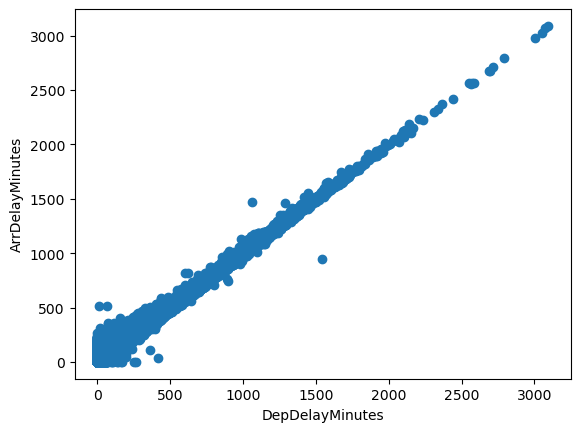

In [16]:
# Arrival delay is strongly linearly correlated with departure delay.
# Consider using Arrival Delay only. We probably care more about arrival delay than departure delay (if key stakeholders are passengers).
plt.scatter(df_relevant_nonull.DepDelayMinutes, df_relevant_nonull.ArrDelayMinutes)
plt.xlabel('DepDelayMinutes')
plt.ylabel('ArrDelayMinutes')
plt.show()

In [17]:
DepartureDelayGroups_table = df_relevant_nonull.DepartureDelayGroups.value_counts().sort_index()
DepartureDelayGroups_table

-2.0       30396
-1.0     3798707
 0.0     1288663
 1.0      388704
 2.0      199691
 3.0      122998
 4.0       82504
 5.0       58181
 6.0       43344
 7.0       32759
 8.0       25203
 9.0       19763
 10.0      15840
 11.0      12683
 12.0      66434
Name: DepartureDelayGroups, dtype: int64

In [18]:
ArrivalDelayGroups_table = df_relevant_nonull.ArrivalDelayGroups.value_counts().sort_index()
ArrivalDelayGroups_table

-2.0     1583783
-1.0     2466704
 0.0     1067324
 1.0      401559
 2.0      199467
 3.0      119535
 4.0       79751
 5.0       56743
 6.0       42103
 7.0       31781
 8.0       24765
 9.0       19838
 10.0      15457
 11.0      12258
 12.0      64802
Name: ArrivalDelayGroups, dtype: int64

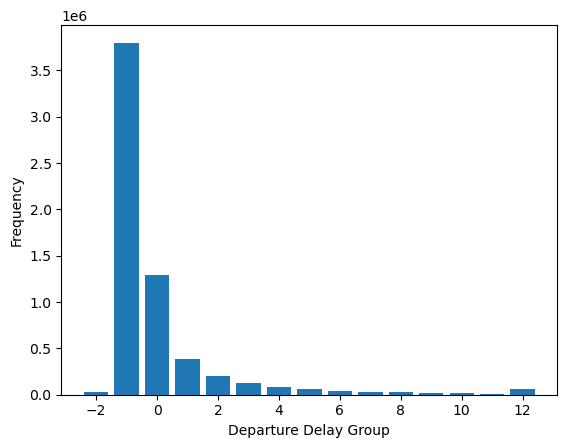

In [19]:
plt.bar(DepartureDelayGroups_table.index, DepartureDelayGroups_table.values)
plt.xlabel('Departure Delay Group')
plt.ylabel('Frequency')
plt.show()

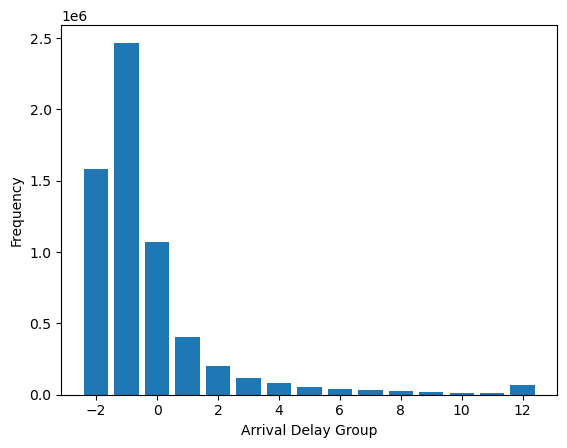

In [20]:
plt.bar(ArrivalDelayGroups_table.index, ArrivalDelayGroups_table.values)
plt.xlabel('Arrival Delay Group')
plt.ylabel('Frequency')
plt.show()

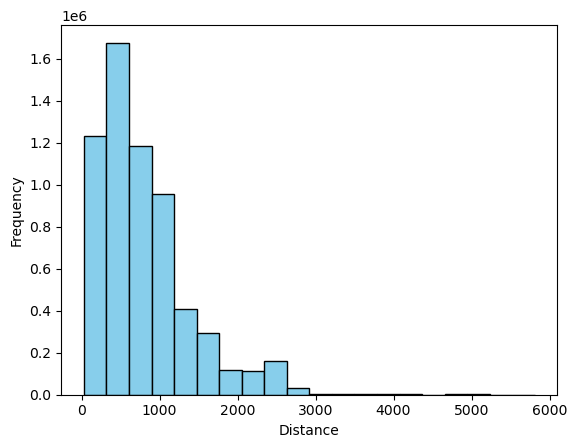

In [21]:
# distance is right skewed
plt.hist(df_relevant_nonull.Distance, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

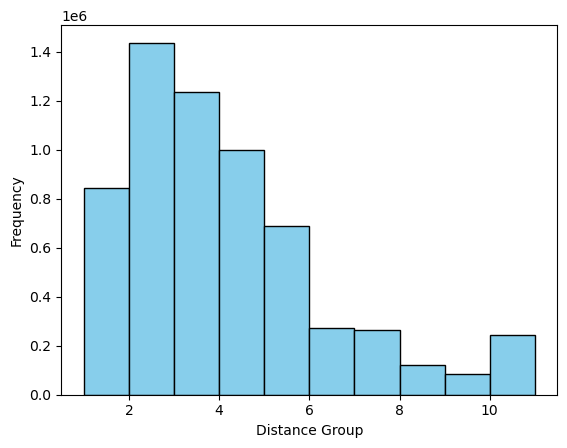

In [22]:
# distance is right skewed
plt.hist(df_relevant_nonull.DistanceGroup, color='skyblue', edgecolor='black')
plt.xlabel('Distance Group')
plt.ylabel('Frequency')
plt.show()

In [23]:
df_relevant_nonull_numerical = df_relevant_nonull.select_dtypes(include='number')
df_relevant_nonull_numerical.shape

(6185870, 22)

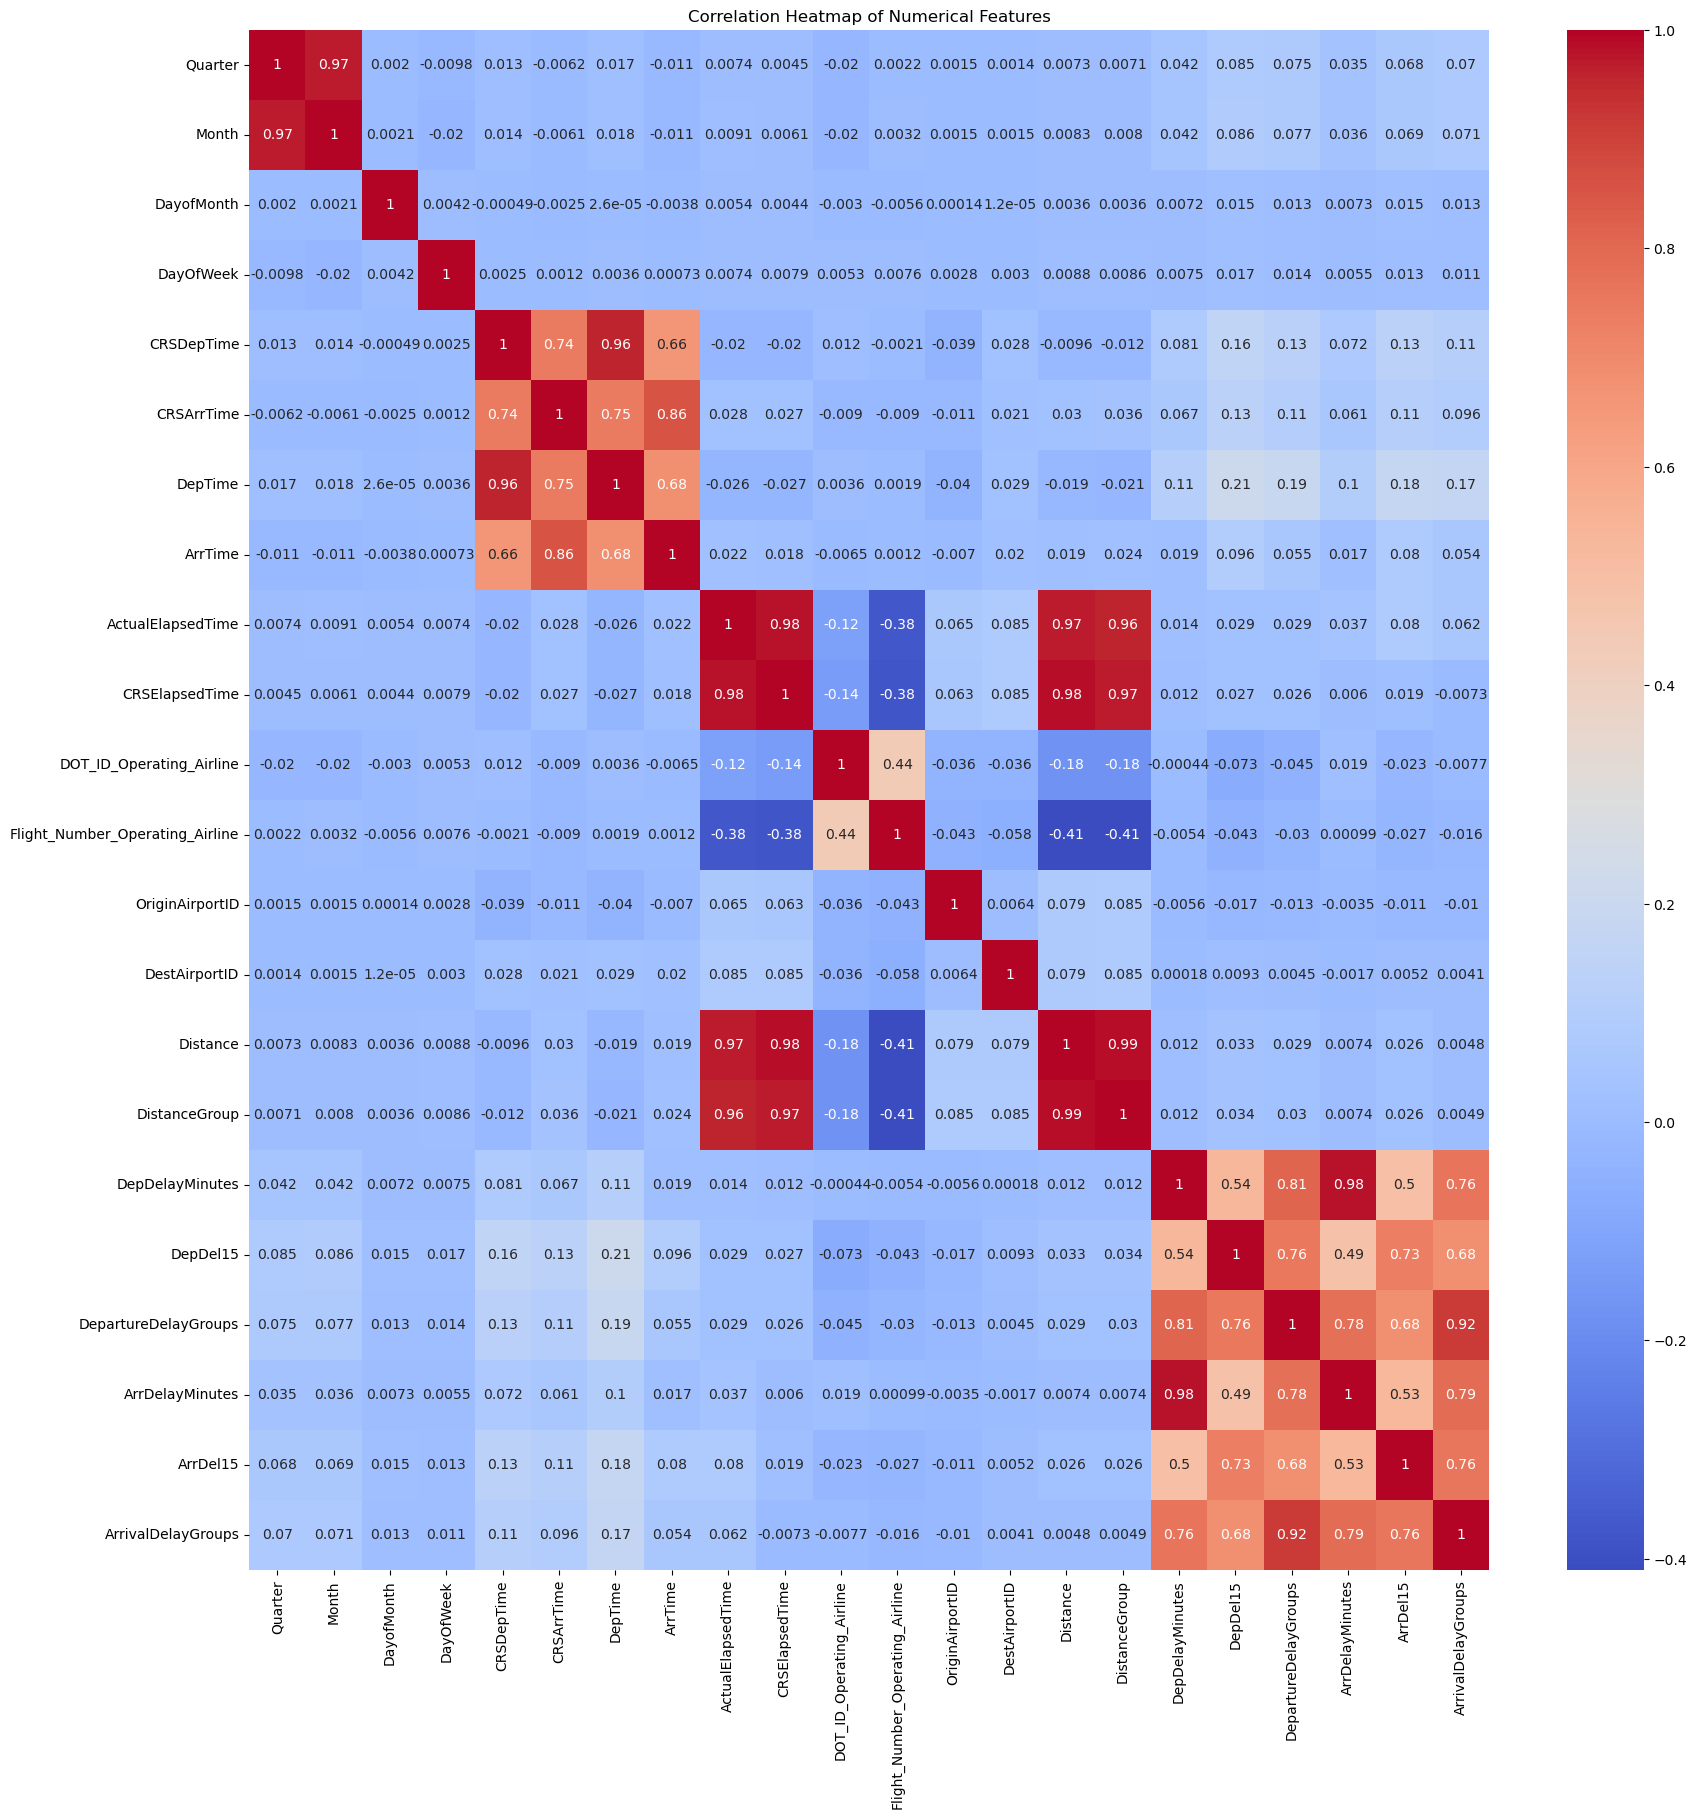

In [24]:
# check correlation
correlation_matrix_scores = df_relevant_nonull_numerical.corr()

# Plot heatmap of correlations
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix_scores, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

When selecting the following features, select only 1 feature in each group due to correlation (or because they basically mean the same thing):  

1. Quarter & Month
2. CRSDepTime & CRSArrTime
3. DOT_ID_Operating_Airline, Operating_Airline, Airline
4. OriginAirportID, Origin, OriginCityName
5. DestAirportID, Dest, DestCityName
6. Distance & DistanceGroup


When selecting a target variable, select 1 based on your type of prediction:

1. Continuous Prediction: ArrDelayMinutes
2. Binary Prediction: ArrDel15
3. Categorical Prediction: ArrivalDelayGroups

In [25]:
# This may take a while. (2-3 minutes)
# df_relevant_nonull.to_csv('Cleaned_Combined_Flights_2021.csv')

# FEATURE ENGINEERING

### New Features

In [26]:
# Create a new categorical variable for Weekdays vs. Weekends
def weekday_or_weekend(day):
    if day in [6, 7]:  # Saturday (6) and Sunday (7)
        return 'Weekend'
    else:
        return 'Weekday'


df_relevant_nonull = df_relevant_nonull.copy()
# Apply the function to the 'DayOfWeek' column
df_relevant_nonull['WeekdayOrWeekend'] = df_relevant_nonull['DayOfWeek'].apply(weekday_or_weekend)

In [27]:
df_relevant_nonull['FlightDate'] = pd.to_datetime(df_relevant_nonull['FlightDate'])

# Extract useful time-based features
df_relevant_nonull['Season'] = df_relevant_nonull['Month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else
                                              'Spring' if x in [3, 4, 5] else
                                              'Summer' if x in [6, 7, 8] else
                                              'Fall')  # Add season based on the month

In [28]:
# Create a uniform time scale (minutes)
def time_to_minutes(time):
    # Extract hours and minutes, handling edge cases like NaN
    if pd.isnull(time):
        return 0
    hours = time // 100
    minutes = time % 100
    return hours * 60 + minutes

# Apply the conversion
df_relevant_nonull['CRSDepTimeMinutes'] = df_relevant_nonull['CRSDepTime'].apply(time_to_minutes)
df_relevant_nonull['DepTimeMinutes'] = df_relevant_nonull['DepTime'].apply(time_to_minutes)

# Calculate Arr_deviation
# 1. Departure Deviation
df_relevant_nonull['DepDeviation'] = df_relevant_nonull['DepTimeMinutes'] - df_relevant_nonull['CRSDepTimeMinutes']

# 2. In-Flight Duration Deviation
df_relevant_nonull['DurationDeviation'] = df_relevant_nonull['ActualElapsedTime'] - df_relevant_nonull['CRSElapsedTime']

# Combine both to calculate Arr_deviation
df_relevant_nonull['Arr_deviation'] = df_relevant_nonull['DepDeviation'] + df_relevant_nonull['DurationDeviation']

#Drop irrelevant columns
df_relevant_nonull.drop(['DepDeviation', 'DurationDeviation'], axis=1, inplace=True)

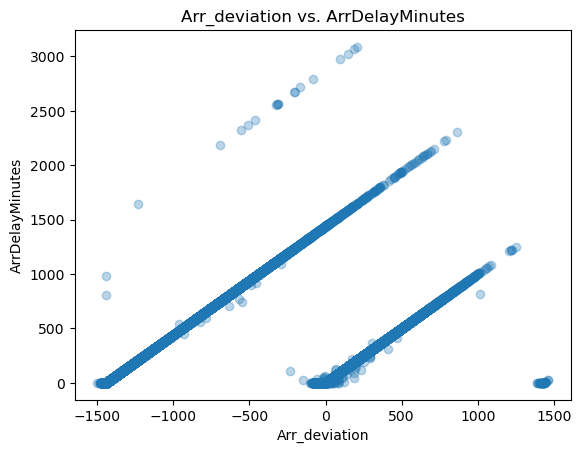

In [29]:
#Assess correlation of new feature
# Scatter plot of Arr_deviation vs ArrDelayMinutes
plt.scatter(df_relevant_nonull['Arr_deviation'], df_relevant_nonull['ArrDelayMinutes'], alpha=0.3)
plt.xlabel('Arr_deviation')
plt.ylabel('ArrDelayMinutes')
plt.title('Arr_deviation vs. ArrDelayMinutes')
plt.show()

In [30]:
#Low correlation, hence to provide more predictive benefits
correlation = df_relevant_nonull[['Arr_deviation', 'ArrDelayMinutes']].corr()
print(correlation)

                 Arr_deviation  ArrDelayMinutes
Arr_deviation         1.000000         0.133804
ArrDelayMinutes       0.133804         1.000000


In [31]:
#Proxy for Tail_number

# Avg number of delay minutes per aircraft (Tail_Number)
avg_delays_per_aircraft = df_relevant_nonull.groupby('Tail_Number')['DepDelayMinutes'].mean()

# Map the average delay back to the original DataFrame
df_relevant_nonull['AvgDelaysPerAircraft'] = df_relevant_nonull['Tail_Number'].map(avg_delays_per_aircraft)

# Replace NaN with 0 for aircraft with no recorded delays
df_relevant_nonull['AvgDelaysPerAircraft'].fillna(0, inplace=True)

In [32]:
# Total number of flights per airline
total_flights_per_airline = df_relevant_nonull['Airline'].value_counts()

# Count the number of unique flight dates
unique_flight_dates = df_relevant_nonull['FlightDate'].nunique()

# Calculate the average number of flights per day for each airline
avg_flights_per_day_per_airline = total_flights_per_airline / unique_flight_dates

# Map the average flights per day back to the original DataFrame
df_relevant_nonull['AvgFlightsPerDay'] = df_relevant_nonull['Airline'].map(avg_flights_per_day_per_airline)


In [33]:
#Proxy feature for categorical airport features

total_flights = len(df_relevant_nonull)

# Total number of flights per Origin airport
origin_capacity = df_relevant_nonull.groupby('Origin')['FlightDate'].count().reset_index()
origin_capacity.rename(columns={'FlightDate': 'TotalFlightsFromOrigin'}, inplace=True)

# Merge Origin capacity
df_relevant_nonull = df_relevant_nonull.merge(origin_capacity, on='Origin', how='left')
df_relevant_nonull.rename(columns={'TotalFlightsFromOrigin': 'Origin_capacity'}, inplace=True)
df_relevant_nonull['Origin_capacity'] = (df_relevant_nonull['Origin_capacity']/total_flights).round(4)


# Total number of flights for each destination airport
dest_capacity = df_relevant_nonull.groupby('Dest')['FlightDate'].count().reset_index()
dest_capacity.rename(columns={'FlightDate': 'TotalFlightsToDest'}, inplace=True)

# Merge Destination capacity
df_relevant_nonull = df_relevant_nonull.merge(dest_capacity, on='Dest', how='left')
df_relevant_nonull.rename(columns={'TotalFlightsToDest': 'Dest_capacity'}, inplace=True)
df_relevant_nonull['Dest_capacity'] = (df_relevant_nonull['Dest_capacity']/total_flights).round(4)

### One-Hot Encoding

In [34]:
df_relevant_nonull = pd.get_dummies(df_relevant_nonull, columns=['WeekdayOrWeekend'], prefix='Is')

#Keep only is_Weekend due to perfect correlation?
#df_relevant_nonull = df_relevant_nonull.drop(columns=['Is_Weekday'])

In [35]:
# One-hot encode the 'Season' column
df_relevant_nonull = pd.get_dummies(df_relevant_nonull, columns=['Season'], prefix='Is')

In [36]:
categorical_columns = df_relevant_nonull.select_dtypes(include=['object'])
print(categorical_columns.head())

  Operating_Airline                Airline Tail_Number Origin  \
0                OO  SkyWest Airlines Inc.      N728SK    SGU   
1                OO  SkyWest Airlines Inc.      N752SK    PHX   
2                OO  SkyWest Airlines Inc.      N766SK    MHT   
3                OO  SkyWest Airlines Inc.      N752EV    DFW   
4                OO  SkyWest Airlines Inc.      N715SK    PHX   

          OriginCityName OriginStateName Dest  \
0         St. George, UT            Utah  PHX   
1            Phoenix, AZ         Arizona  SGU   
2         Manchester, NH   New Hampshire  ORD   
3  Dallas/Fort Worth, TX           Texas  TRI   
4            Phoenix, AZ         Arizona  BFL   

                         DestCityName DestStateName  
0                         Phoenix, AZ       Arizona  
1                      St. George, UT          Utah  
2                         Chicago, IL      Illinois  
3  Bristol/Johnson City/Kingsport, TN     Tennessee  
4                     Bakersfield, CA    Cal

In [37]:
#View unique values
# df_relevant_nonull['Operating_Airline'].value_counts()

In [38]:
# One-hot encode the 'Operating Arline' column
df_relevant_nonull = pd.get_dummies(df_relevant_nonull, columns=['Airline'])

In [39]:
df_relevant_nonull.tail()

,Quarter,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,DepTime,ArrTime,ActualElapsedTime,CRSElapsedTime,...,"Airline_GoJet Airlines, LLC d/b/a United Express",Airline_Hawaiian Airlines Inc.,Airline_Horizon Air,Airline_JetBlue Airways,Airline_Mesa Airlines Inc.,Airline_Republic Airlines,Airline_SkyWest Airlines Inc.,Airline_Southwest Airlines Co.,Airline_Spirit Air Lines,Airline_United Air Lines Inc.
6185865,2,6,1,2,1255,1430,1301.0,1421.0,80.0,95.0,...,0,0,0,0,0,0,0,1,0,0
6185866,2,6,1,2,730,900,727.0,845.0,78.0,90.0,...,0,0,0,0,0,0,0,1,0,0
6185867,2,6,1,2,800,1110,757.0,1101.0,124.0,130.0,...,0,0,0,0,0,0,0,1,0,0
6185868,2,6,1,2,1300,1620,1252.0,1559.0,127.0,140.0,...,0,0,0,0,0,0,0,1,0,0
6185869,2,6,1,2,1925,2055,1948.0,2116.0,88.0,90.0,...,0,0,0,0,0,0,0,1,0,0


In [40]:
#Find a proxy for arrival and destination states to encode patterns other than airport capacity.


In [41]:
df_relevant_nonull.drop(['Tail_Number', 'OriginCityName', 'Origin', 'OriginStateName'
                        , 'Dest', 'DestCityName', 'DestStateName', 'Operating_Airline', 'FlightDate'] 
                        , axis=1, inplace=True)

In [42]:
# df_relevant_nonull.to_csv('Transformed_Combined_Flights_2021.csv')

# TEST TRAIN SPLIT

In [43]:
# Remove all features that directly relate to delay to ensures the model is not learning from target-related features.
X = (df_relevant_nonull
     .drop(columns=['ArrDelayMinutes',  # Actual delay in minutes (target leakage)
                    'ArrDel15',         # Binary indicator for >15-minute delay (target)
                    'ArrivalDelayGroups',  # Delay grouped into intervals (target leakage)
                    'Arr_deviation',    # Deviation in arrival time (derived from delays)
                    'DepDelayMinutes',  # Departure delay in minutes (target leakage)
                    'DepDel15',         # Binary indicator for >15-minute departure delay
                    'DepartureDelayGroups'# Departure delay grouped into intervals
                   ])
    )  # Final feature set

y = df_relevant_nonull['ArrDel15']  # Target Var

#used random stratification because of class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes(include='bool').columns})
X_test = X_test.astype({col: 'int' for col in X_test.select_dtypes(include='bool').columns})

In [44]:
# distribution in both training and testing sets
print("Training has:")
print(y_train.value_counts(normalize=True))

print("\nTesting has:")
print(y_test.value_counts(normalize=True))

Training has:
0.0    0.827339
1.0    0.172661
Name: ArrDel15, dtype: float64

Testing has:
0.0    0.827339
1.0    0.172661
Name: ArrDel15, dtype: float64


### Standardization

In [45]:
#Change all hh:mm time columns to minutes??
# df_relevant_nonull.info()

In [46]:
standard_scaler = StandardScaler()

numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

# Create a copy of the original X_train and X_test for standardization
X_train_std = X_train.copy()
X_test_std = X_test.copy()

X_train_std[numerical_cols] = standard_scaler.fit_transform(X_train_std[numerical_cols])
X_test_std[numerical_cols] = standard_scaler.transform(X_test_std[numerical_cols])

# MODEL SELECTION - Model 1

In [47]:
# Baseline Model 1A
# Accuracy if we predict majority class is 82%, aiming to achieve higher accuracy than this.

#LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression with class balancing
lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=500)

# Fit on standardized data
lr.fit(X_train_std, y_train)

# Predictions
y_pred_lr = lr.predict(X_test_std)
y_pred_prob_lr = lr.predict_proba(X_test_std)[:, 1]  # Probability for class 1

# Evaluate
print("Logistic Regression Metrics")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

Logistic Regression Metrics
Accuracy: 0.7572685814606515
Precision: 0.39079541761251263
Recall: 0.7261342995711851
F1 Score: 0.5081250010237125
ROC-AUC Score: 0.8163931379916424

Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.76      0.84   1023562
         1.0       0.39      0.73      0.51    213612

    accuracy                           0.76   1237174
   macro avg       0.66      0.74      0.67   1237174
weighted avg       0.84      0.76      0.78   1237174



Decision Tree Metrics
Accuracy: 0.749750641381083
Precision: 0.35376384056160537
Recall: 0.5435368799505645
F1 Score: 0.4285825024824017
ROC-AUC Score: 0.7262288356094835

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.79      0.84   1023562
         1.0       0.35      0.54      0.43    213612

    accuracy                           0.75   1237174
   macro avg       0.62      0.67      0.63   1237174
weighted avg       0.80      0.75      0.77   1237174



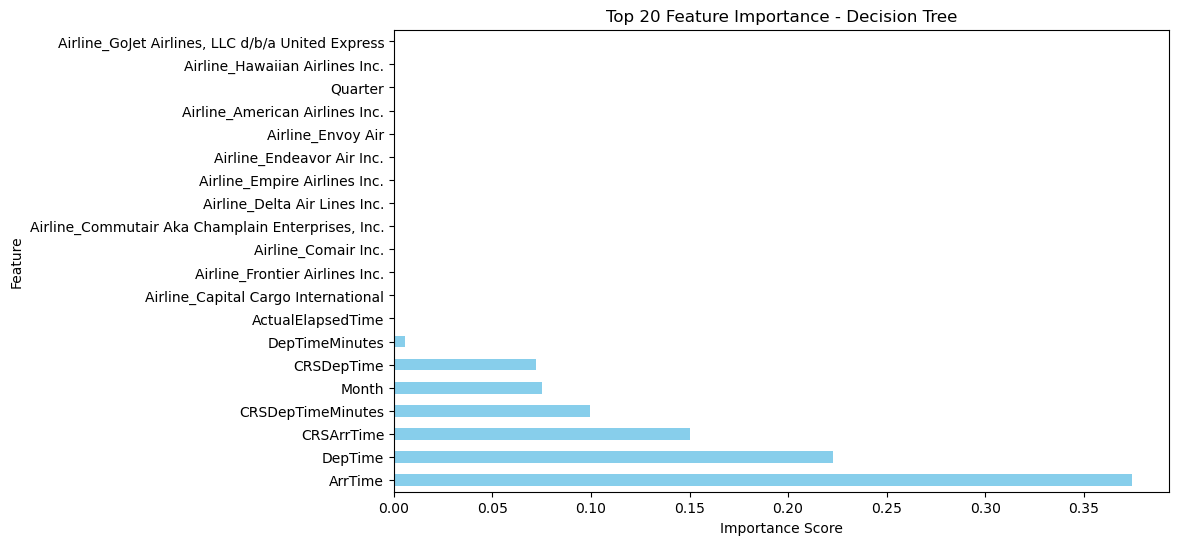

In [48]:
# Baseline Model 1B
#DECISION TREE (with feature importance)

dt = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)

# Fit the model on the training data
dt.fit(X_train, y_train)

# Predictions on the test set
y_pred_dt = dt.predict(X_test)
y_pred_prob_dt = dt.predict_proba(X_test)[:, 1]  # Probability for class 1

# Evaluate the model
print("Decision Tree Metrics")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))

# Feature Importance
feature_importance = pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Visualize feature importance
plt.figure(figsize=(10, 6))
feature_importance.head(20).plot(kind='barh', color='skyblue')
plt.title("Top 20 Feature Importance - Decision Tree")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [49]:
# Baseline Model 1C (Takes ~10 minutes)
# RANDOM FOREST CLASSIFIER

rf = RandomForestClassifier(
    n_estimators=100, max_depth=20,class_weight='balanced',random_state=42)

# Fit
rf.fit(X_train, y_train, verbose=3)

# Predictions
y_pred_rf = rf.predict(X_test)
y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]  # Probability for class 1

# Evaluate
print("Random Forest Metrics")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Feature Importance Visualization
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 20 important features
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'][:20], feature_importances['Importance'][:20])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importance - Random Forest")
plt.gca().invert_yaxis()
plt.show()

TypeError: BaseForest.fit() got an unexpected keyword argument 'verbose'

# Metrics Evaluation - Logistic Regression


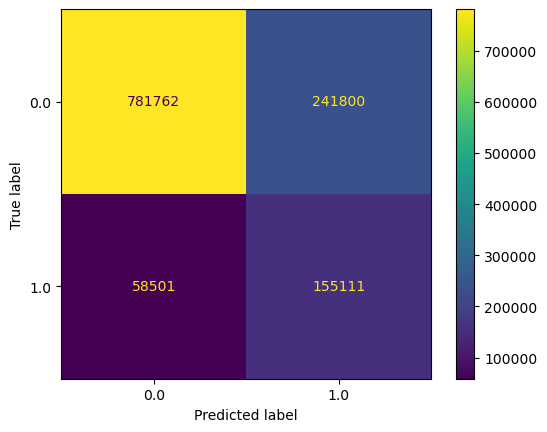

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()

In [51]:
#Adjusting the decision threshold
optimal_threshold = 0.4 
custom_preds = (y_pred_prob_lr >= optimal_threshold).astype(int)

# Evaluate with the new threshold
print("Custom Threshold Metrics")
print("Accuracy:", accuracy_score(y_test, custom_preds))
print("Precision:", precision_score(y_test, custom_preds))
print("Recall:", recall_score(y_test, custom_preds))
print("F1 Score:", f1_score(y_test, custom_preds))

Custom Threshold Metrics
Accuracy: 0.6442586087324823
Precision: 0.3052861966755383
Recall: 0.8312407542647416
F1 Score: 0.4465645591268045


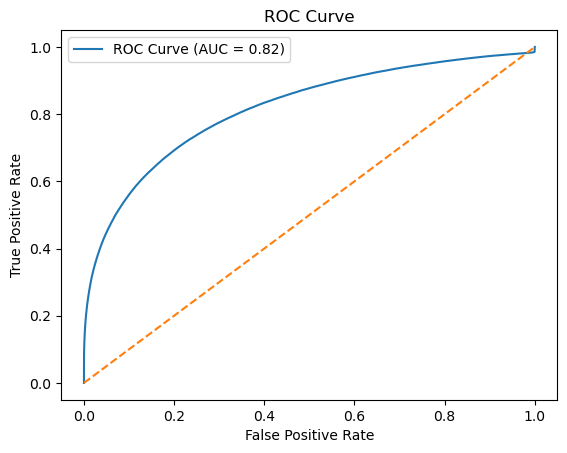

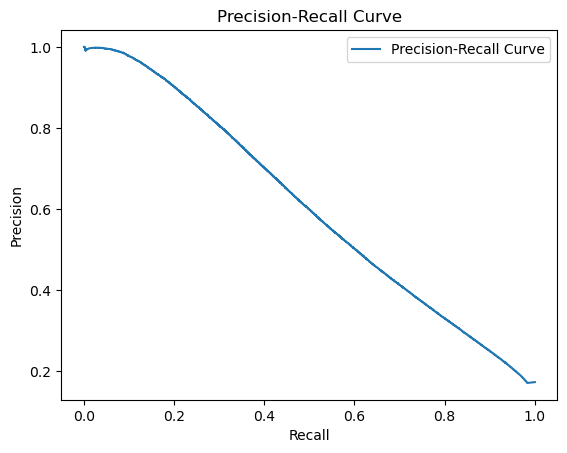

In [52]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_lr)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_lr)

plt.figure()
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predictions at the default threshold (0.5)
baseline_preds = (y_pred_prob_lr >= 0.5).astype(int)

# Evaluate performance at baseline threshold
baseline_accuracy = accuracy_score(y_test, baseline_preds)
baseline_precision = precision_score(y_test, baseline_preds)
baseline_recall = recall_score(y_test, baseline_preds)
baseline_f1 = f1_score(y_test, baseline_preds)

# Print baseline metrics
print("Baseline Metrics (Threshold = 0.5):")
print("Accuracy:", baseline_accuracy)
print("Precision:", baseline_precision)
print("Recall:", baseline_recall)
print("F1 Score:", baseline_f1)

Baseline Metrics (Threshold = 0.5):
Accuracy: 0.7572685814606515
Precision: 0.39079541761251263
Recall: 0.7261342995711851
F1 Score: 0.5081250010237125


### Finding best threshold for maximizing F1 score and calculating metrics at that threshold

In [54]:
#Determine Optimal Threshold

from sklearn.metrics import precision_recall_curve

# Generate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_lr)

# Calculate F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores = f1_scores[:-1]  # Excluding the last score since it has no corresponding threshold

# Find the index of the best F1 score
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print(f"Best Threshold: {best_threshold}, Best F1 Score: {f1_scores[best_idx]}")

Best Threshold: 0.6217004138335321, Best F1 Score: 0.5495193372309898


In [55]:
# Apply the best threshold
custom_preds = (y_pred_prob_lr >= best_threshold).astype(int)

# Evaluate performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Metrics at Best Threshold")
print("Accuracy:", accuracy_score(y_test, custom_preds))
print("Precision:", precision_score(y_test, custom_preds))
print("Recall:", recall_score(y_test, custom_preds))
print("F1 Score:", f1_score(y_test, custom_preds))

Metrics at Best Threshold
Accuracy: 0.8405002044983163
Precision: 0.5362765061556216
Recall: 0.5634327659494784
F1 Score: 0.5495193372309898


### Comparing metrics at the different thresholds

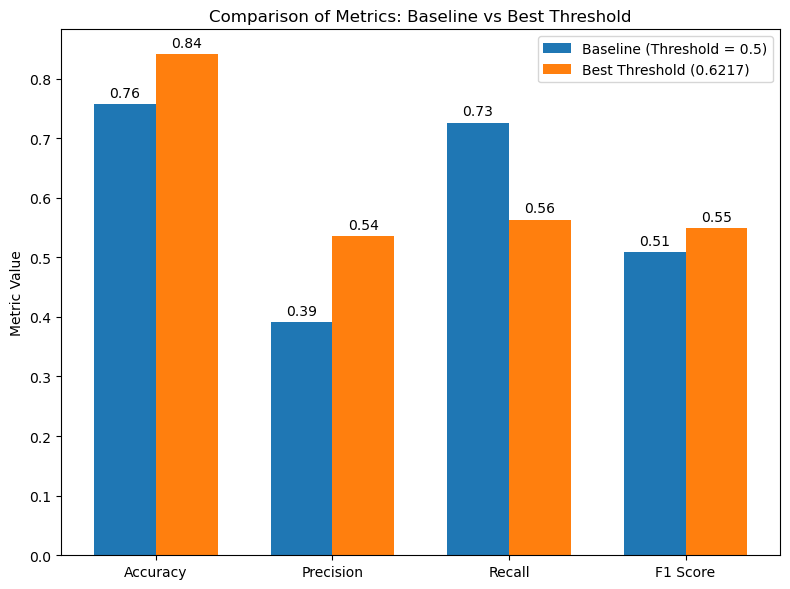

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for visualization
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
baseline_values = [0.7573, 0.3908, 0.7261, 0.5081]  # Baseline metrics
best_threshold_values = [0.8405, 0.5363, 0.5634, 0.5495]  # Best threshold metrics

# Bar chart to compare metrics
x = np.arange(len(metrics))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, baseline_values, width, label='Baseline (Threshold = 0.5)')
bars2 = ax.bar(x + width/2, best_threshold_values, width, label='Best Threshold (0.6217)')


ax.set_ylabel('Metric Value')
ax.set_title('Comparison of Metrics: Baseline vs Best Threshold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Value labels on the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()

### Hyperparameter Tuning


In [57]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split


X = df_relevant_nonull.drop(columns=[
    'ArrDelayMinutes',        # Actual delay in minutes (target leakage)
    'ArrDel15',               # Binary indicator for >15-minute delay (target)
    'ArrivalDelayGroups',     # Delay grouped into intervals (target leakage)
    'Arr_deviation',          # Deviation in arrival time (derived from delays)
    'DepDelayMinutes',        # Departure delay in minutes (target leakage)
    'DepDel15',               # Binary indicator for >15-minute departure delay
    'DepartureDelayGroups',   # Departure delay grouped into intervals
    'ArrTime',                # Actual arrival time, unavailable at prediction
    'Quarter',  # Higly correlated with month
    'DistanceGroup',  # Higly correlated with distance
    'ActualElapsedTime', # Higly correlated with CRSElapsedTime
    'CRSDepTime',  # will keep crsdeptimeminutes
    'DepTimeMinutes', 
    'DepTime',   # will not normally be known
    'CRSArrTime'  # highly correlated with CRSDepTime
])

In [58]:
# Target variable
y = df_relevant_nonull['ArrDel15']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [59]:
X_train_sub, _, y_train_sub, _ = train_test_split(X_train_std, y_train, test_size=0.2, random_state=42)
X_test_sub, _, y_test_sub, _ = train_test_split(X_test_std, y_test, test_size=0.2, random_state=42)

In [60]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1],
    'penalty': ['l2'],  
    'solver': ['liblinear'], 
    'class_weight': ['balanced']
}

random_search = RandomizedSearchCV(
    LogisticRegression(random_state=42, max_iter=50),
    param_distributions=param_grid,
    n_iter=3,
    cv=2, 
    scoring='roc_auc',
    random_state=42,
    n_jobs=1,  # Used only one core to reduce memory demand
    verbose=2
)

In [61]:
# Fit the model
random_search.fit(X_train_sub, y_train_sub)


/Users/naimaamraan/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=3. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=  28.6s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=  34.7s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=liblinear; total time=  22.3s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=liblinear; total time=  25.5s


RandomizedSearchCV(cv=2,
                   estimator=LogisticRegression(max_iter=50, random_state=42),
                   n_iter=3, n_jobs=1,
                   param_distributions={'C': [0.1, 1],
                                        'class_weight': ['balanced'],
                                        'penalty': ['l2'],
                                        'solver': ['liblinear']},
                   random_state=42, scoring='roc_auc', verbose=2)

In [62]:
# Display the best parameters and performance
print("Best Parameters:", random_search.best_params_)
print("Best ROC-AUC Score:", random_search.best_score_)

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_std)
y_pred_prob = best_model.predict_proba(X_test_std)[:, 1]



Best Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'class_weight': 'balanced', 'C': 1}
Best ROC-AUC Score: 0.6712985901958168


In [63]:
# Predict on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_std)
y_pred_prob = best_model.predict_proba(X_test_std)[:, 1]

# Evaluate on the test set
print("\nTest Set Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))

# Compare with cross-validation score
print("\nComparison:")
print("Cross-Validated ROC-AUC Score:", random_search.best_score_)
print("Test ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))



Test Set Metrics:
Accuracy: 0.6253704006065436
Precision: 0.2586328808726194
Recall: 0.6267063648109656
F1 Score: 0.3661576585077664
ROC-AUC Score: 0.6727973060633268

Comparison:
Cross-Validated ROC-AUC Score: 0.6712985901958168
Test ROC-AUC Score: 0.6727973060633268
